### Reference: https://arxiv.org/pdf/1908.11170.pdf

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gwpy.plot import Plot
from gwpy.timeseries import TimeSeries
import scipy

In [139]:
df = pd.read_csv("g2net-gravitational-wave-detection/training_labels.csv")
df["path"]= df["id"].apply(lambda x : "g2net-gravitational-wave-detection/train/" +x[0] +"/"+x[1] +"/"+x[2] +"/" + x+".npy")

In [3]:
def getting_the_signal(file_number:int):
    path = df['path'][file_number]
    signal_data = np.load(path)
    return signal_data

def plot_time_data(d1, d2, d3):
    plot = Plot(d1, d2, d3, separate=True, sharex=True, figsize=[12, 8])
    ax = plot.gca()
    ax.set_xlim(0,2)
    ax.set_xlabel('Time [s]')
    plt.tight_layout()

#### We'll be applying window function to out signal in order to reduce the spectral leakage (https://en.wikipedia.org/wiki/Spectral_leakage)

#### There are several types of window function. Here, I tried Kaiser, Dolph–Chebyshev window, Hann–Poisson window, Planck–Bessel window and ended up with tukey as it does the job without reducing the amplitude of the signal or window the most of the signal.

In [4]:

def tukey(M, alpha=0.15, needs_trunc=False):
    n = np.arange(0, M)
    width = int(np.floor(alpha*(M-1)/2.0))
    
    n1 = n[0:width+1]
    n2 = n[width+1:M-width-1]
    n3 = n[M-width-1:]

    w1 = 0.5 * (1 + np.cos(np.pi * (-1 + 2.0*n1/alpha/(M-1))))
    w2 = np.ones(n2.shape)
    w3 = 0.5 * (1 + np.cos(np.pi * (-2.0/alpha + 1 + 2.0*n3/alpha/(M-1))))

    w = np.concatenate((w1, w2, w3))

    return w

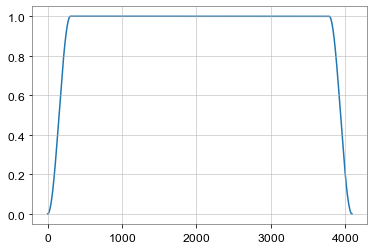

In [5]:
window = tukey(4096,alpha=0.15)
plt.plot(window)

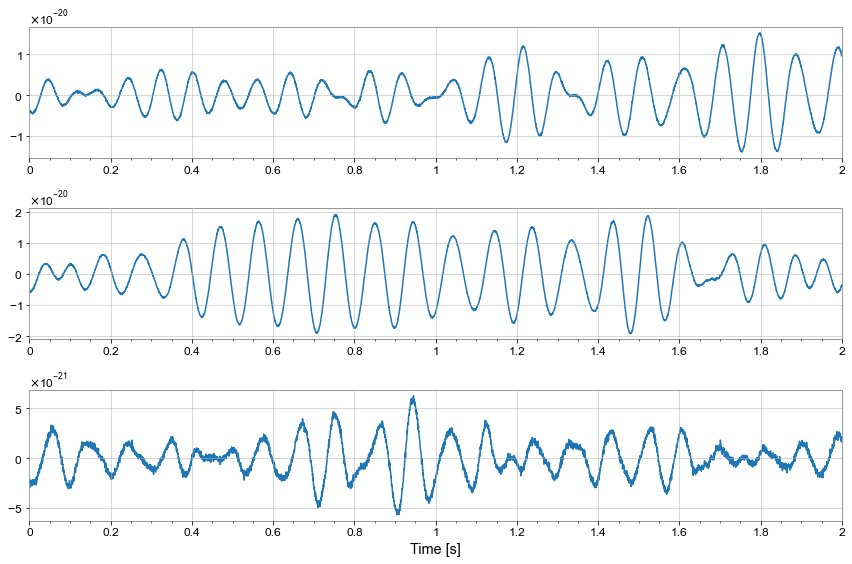

                                        ______After applying Window______                                 


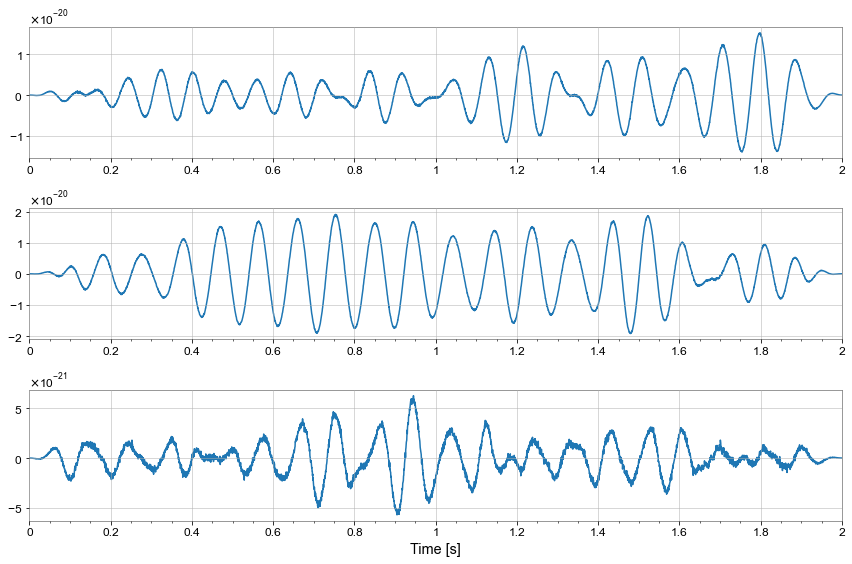

In [19]:
data=np.load('g2net-gravitational-wave-detection/train/0/0/0/000a5b6e5c.npy')

d1 = TimeSeries(data[0,:], sample_rate=2048)
d2 = TimeSeries(data[1,:], sample_rate=2048)
d3 = TimeSeries(data[2,:], sample_rate=2048)
plot_time_data(d1, d2, d3)
plt.show()
print('                                        ______After applying Window______                                 ')
plot_time_data(d1*window, d2*window, d3*window)
plt.show()

### I chose the alpha as 0.15 after tinkering with various value. As the span of the signal is 2 seconds we may lose the signal presence in the beginning if the value is greater than 0.2.

In [20]:
import torch
from torch.fft import fft, ifft

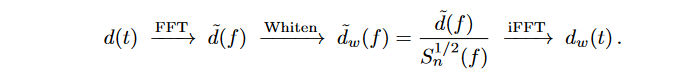

#### First we'll whiten the signal after applying the window function and then bandpass with pass band [30, 350] inorder to remove the noises

In [73]:
def whiten(signal):
    tukey_win = tukey(4096,0.15)
    ft = fft(torch.from_numpy(signal).float()* tukey_win)
    mag = torch.sqrt(torch.real(ft*torch.conj(ft))) 
    inv = torch.real(ifft(ft/mag)).numpy() * np.sqrt(len(signal)/2)
    return inv
from scipy.signal import butter, filtfilt

def bandpass(signal, sampling_rate=2048, lower_end=30, upper_end=350
    nyquist_frequency = sampling_rate/2.0
    bb, ab = butter(4, [lower_end/nyquist_frequency, upper_end/nyquist_frequency], btype='band')
    return filtfilt(bb, ab, signal)

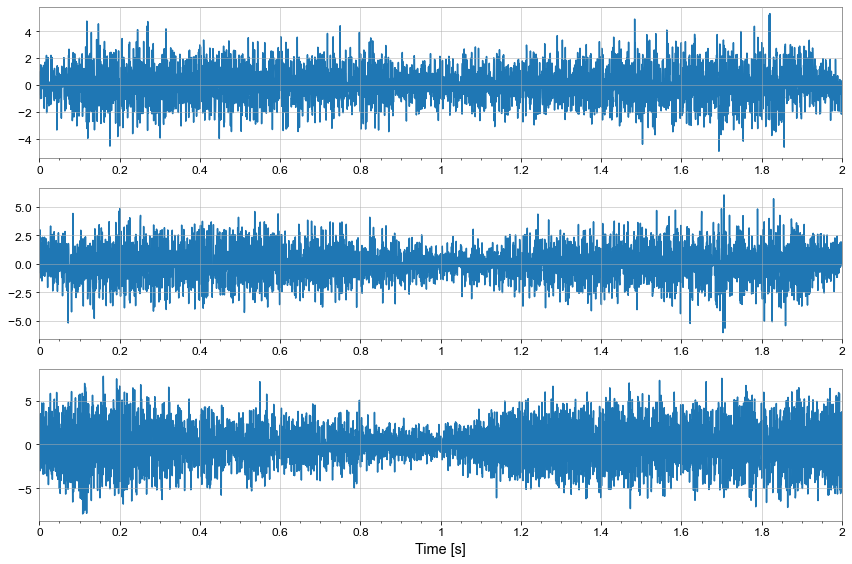

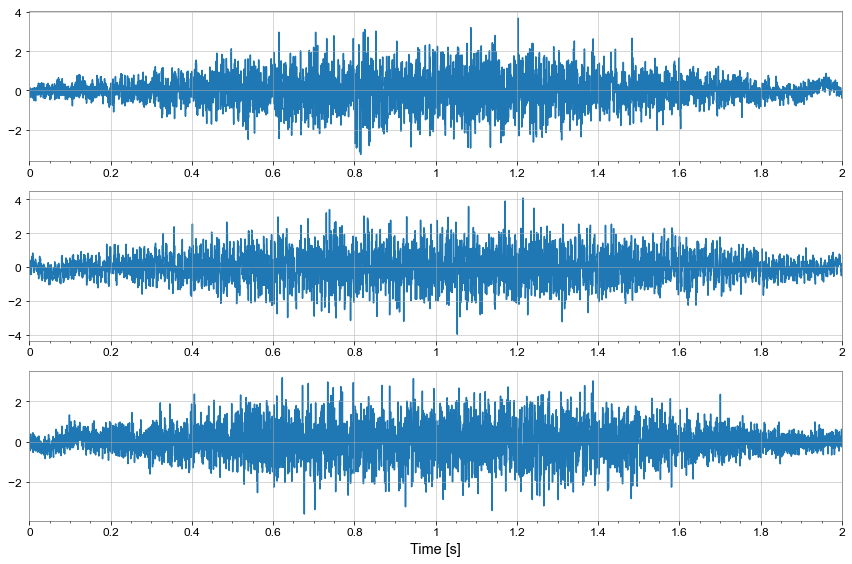

In [74]:
plot_time_data(d1.whiten(window=("tukey",0.15)),d2.whiten(window=("tukey",0.15)),d3.whiten(window=("tukey",0.15)))
plot_time_data((window*d1).whiten(), (window*d2).whiten(), (window*d3).whiten())


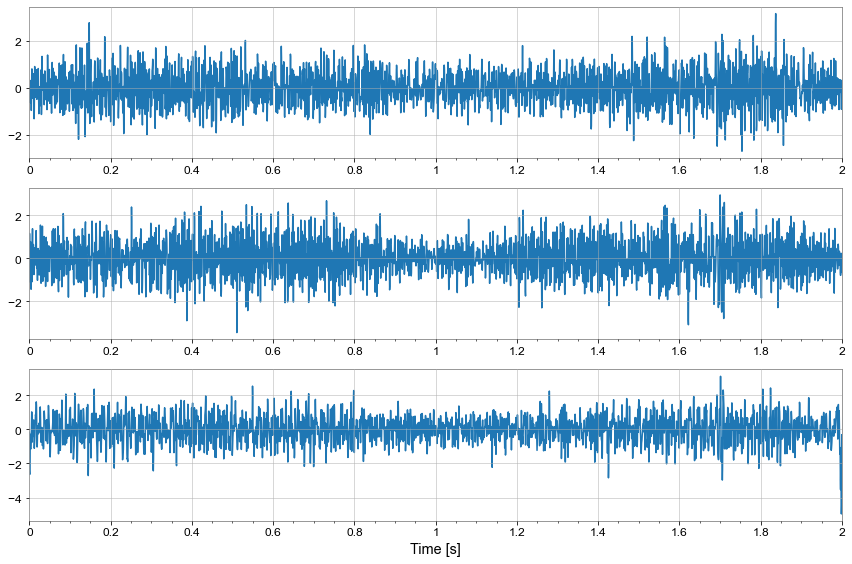

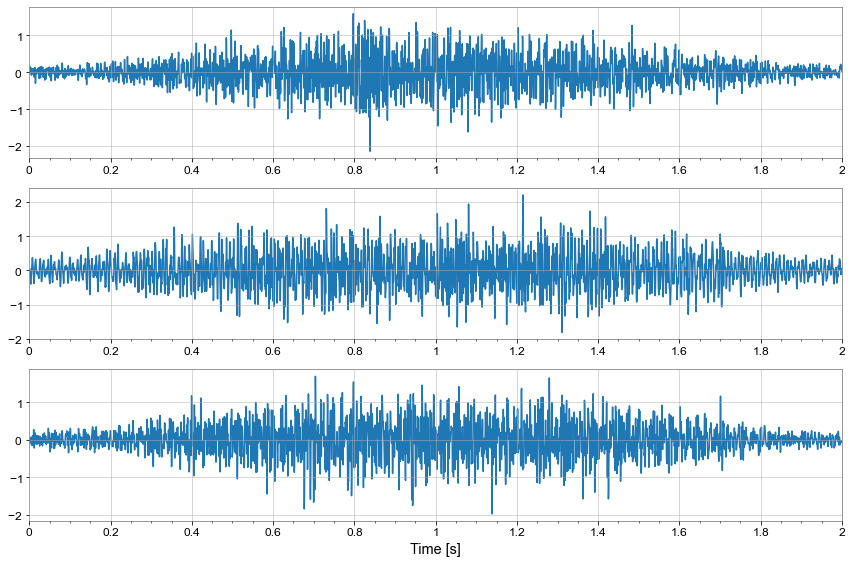

In [141]:
plot_time_data(d1.whiten(window=("tukey",0.15)).bandpass(30,450),d2.whiten(window=("tukey",0.15)).bandpass(30,450),d3.whiten(window=("tukey",0.15)).bandpass(30,450))
plot_time_data((window*d1).whiten().bandpass(30,450), (window*d2).whiten().bandpass(30,450), (window*d3).whiten().bandpass(30,450))

### You can See the difference after applying window function above

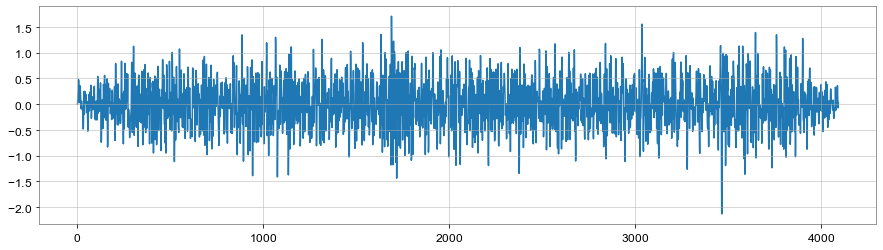

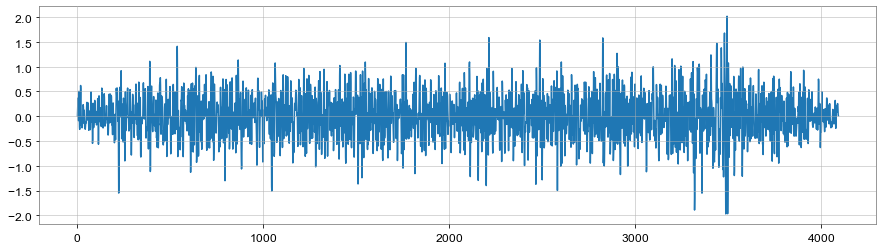

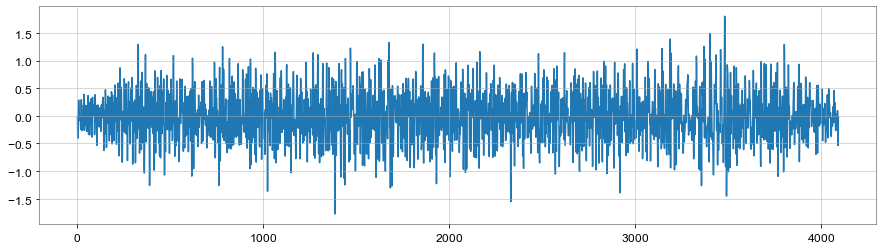

In [135]:
# plot_time_data(bandpass(whiten(d1)), bandpass(whiten(d2)),bandpass(whiten(d3)))
plt.figure(figsize=(15,4))
plt.plot(bandpass(whiten(d1)))
plt.show()
plt.figure(figsize=(15,4))
plt.plot(bandpass(whiten(d2)))
plt.show()
plt.figure(figsize=(15,4))
plt.plot(bandpass(whiten(d3)))
plt.show()


In [136]:
def test_pipeline(f_name):
    data = np.load(f_name)
    d1 = TimeSeries(data[0,:], sample_rate=2048)
    d2 = TimeSeries(data[1,:], sample_rate=2048)
    d3 = TimeSeries(data[2,:], sample_rate=2048)
#     return TimeSeries(whiten(d1), sample_rate=2048),TimeSeries(whiten(d2), sample_rate=2048),TimeSeries(whiten(d3), sample_rate=2048)
    return TimeSeries(bandpass(whiten(d1)), sample_rate=2048),TimeSeries(bandpass(whiten(d2)), sample_rate=2048),TimeSeries(bandpass(whiten(d3)), sample_rate=2048)

### Next we'll use Q_transform to convert it into image

Ref: https://www.researchgate.net/publication/228523955_Constant-Q_transform_toolbox_for_music_processing

                                            Target: 1, Record Number: 194977                                


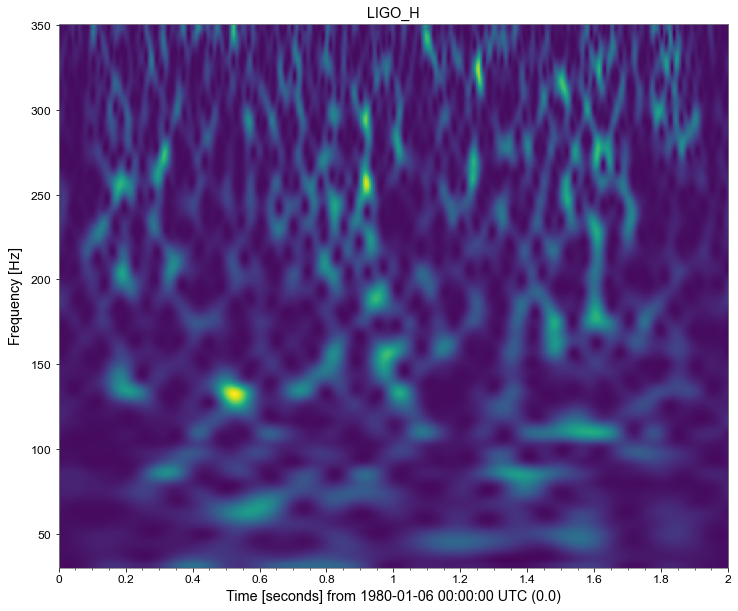

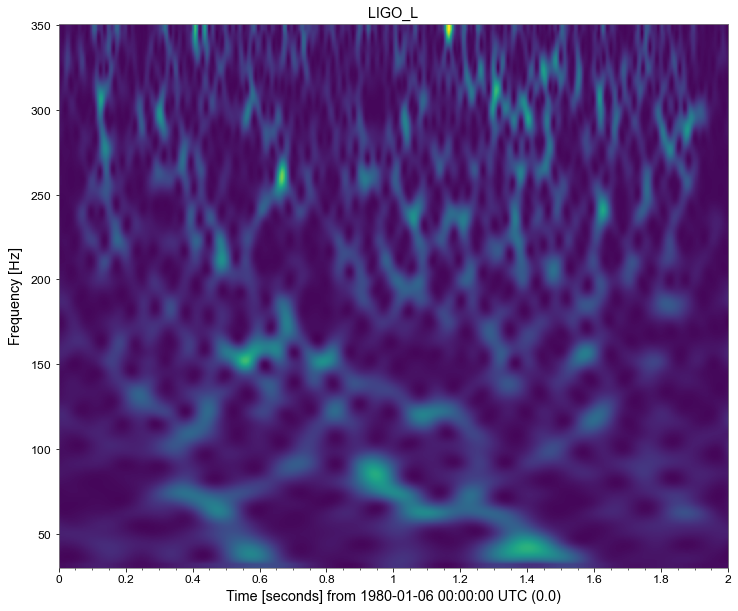

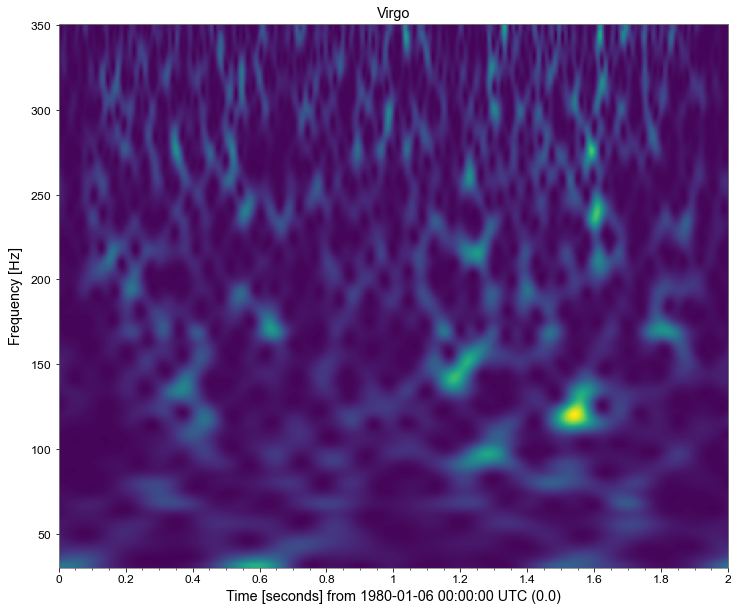

(1000, 2048)

In [155]:
rand = np.random.randint(550000)
sample_data = df.iloc[rand]['path']
target = df.iloc[rand]['target']
print(f'                                            Target: {target}, Record Number: {rand}                                ')

p1, p2, p3 = test_pipeline(f_name=sample_data)
p1_qed = p1.q_transform(qrange=(16,32), frange=(30,350), logf=True, whiten=False, fres=2048)
p2_qed = p2.q_transform(qrange=(16,32), frange=(30,350), logf=True, whiten=False, fres=2048)
p3_qed = p3.q_transform(qrange=(16,32), frange=(30,350), logf=True, whiten=False, fres=2048)

fig1 = p1_qed.plot(figsize=[12, 10])
ax1 = fig1.gca()
ax1.grid(False)
plt.title('LIGO_H')
plt.show()

fig2 = p2_qed.plot(figsize=[12, 10])
ax2 = fig2.gca()
ax2.grid(False)
plt.title('LIGO_L')
plt.show()

fig3 = p3_qed.plot(figsize=[12, 10])
ax3 = fig3.gca()
ax3.grid(False)
plt.title('Virgo')
plt.show()

p1_qed.shape

## Setting up the Pipeline

In [138]:
def test_pipeline_alt(f_name):
    data = np.load(f_name)
    d1 = TimeSeries(data[0,:], sample_rate=2048)
    d2 = TimeSeries(data[1,:], sample_rate=2048)
    d3 = TimeSeries(data[2,:], sample_rate=2048)
#     return TimeSeries(whiten(d1), sample_rate=2048),TimeSeries(whiten(d2), sample_rate=2048),TimeSeries(whiten(d3), sample_rate=2048)
    return TimeSeries(bandpass(whiten(d1)), sample_rate=2048),TimeSeries(bandpass(whiten(d2)), sample_rate=2048),TimeSeries(bandpass(whiten(d3)), sample_rate=2048)

def final_pipeline(f_name,qrange=(14,21),frange=(25,300)):
    image=[]
    p1, p2, p3 = test_pipeline_alt(f_name=f_name)
    p1_qed = p1.q_transform(qrange=qrange, frange=frange, logf=True, whiten=False, fres=2048)
    p2_qed = p2.q_transform(qrange=qrange, frange=frange, logf=True, whiten=False, fres=2048)
    p3_qed = p3.q_transform(qrange=qrange, frange=frange, logf=True, whiten=False, fres=2048)
    
    image.append(p1_qed)
    image.append(p2_qed)
    image.append(p3_qed)

#     image1= (image[0] - np.mean(image[0])) / np.std(image[0])
#     image2= (image[1] - np.mean(image[1])) / np.std(image[1])
#     image3= (image[2] - np.mean(image[2])) / np.std(image[2])
#     img1= np.multiply(image1,image2)
#     img=np.multiply(img1,image3)

    img1= np.multiply(image[0],image[1])
    img=np.multiply(img1,image[2])
    
    return img

#### Here i reduced the dimension to 1 as i didn't have enough computing power to train 3D(We can make it as a 3D image by stacking samples from each labrotary as RGB)

                                                Target: 1,                                 
(1000, 2048)


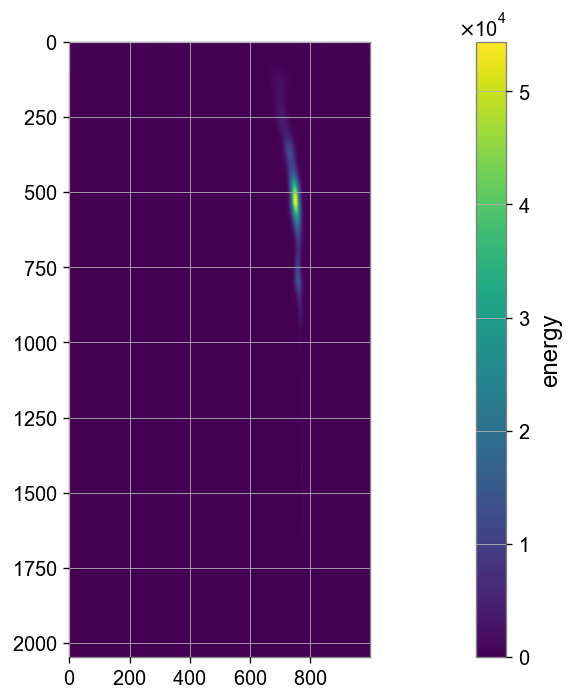

In [158]:
samp_data = df.iloc[315805]['path']
targ = df.iloc[315805]['target']
print(f'                                                Target: {targ},                                 ')

image = final_pipeline(f_name=samp_data)

plt.figure(dpi=120, tight_layout=True, figsize=(18, 6))
plt.imshow(image)
plt.colorbar(label="energy")
print(image.shape)

# We can use these images to train our CNN and predict the output. Instead of CQT we can also try Mel-frequency cepstrum.